#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План действия:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import time 
import warnings


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')

In [2]:
#читаем файл с сайта или с компа 
pth1 = '/datasets/taxi.csv'
pth2 = '/home/dmitrii/Документы/ucheba/taxi.csv'

if os.path.exists('/datasets/taxi.csv'):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
df.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Первичный анализ показывает отсутствие пропусков в данных, что весьма положительно. Преобразуем тип данных object в datetime.

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%d %H:%M:%S' )

Сделаем дату индексом датафрейма, а так же проверим ряд на монотонность:

In [6]:
df.index = df['datetime']
df.drop('datetime',axis=1,inplace=True)

In [7]:
print('монотонность:',df.index.is_monotonic)

монотонность: True


Сделаем ресемплинг с частотой в 1 час(как по заданию):

In [8]:
df = df.resample('1H').sum()

Разложим временной ряд на составляющие: линию тренда, сезонную и шум.

In [9]:
decomposed = seasonal_decompose(df)

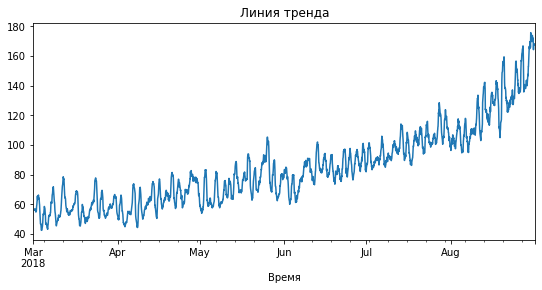

In [10]:
decomposed.trend.plot(title='Линия тренда',figsize=[9,4], xlabel='Время');

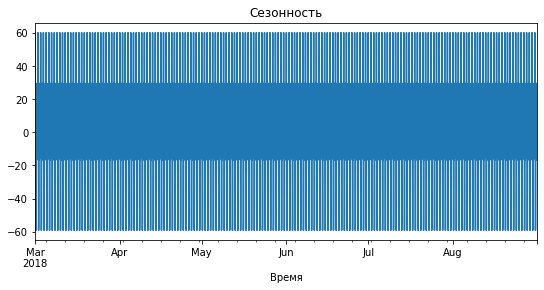

In [11]:
decomposed.seasonal.plot(title='Сезонность',figsize=[9,4], xlabel='Время' );

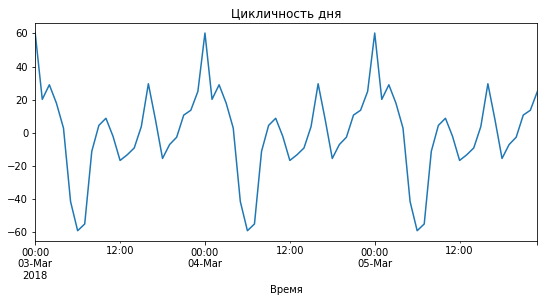

In [12]:
decomposed.seasonal['2018-03-03':'2018-03-05'].plot(title='Цикличность дня',figsize=[9,4], xlabel='Время' );

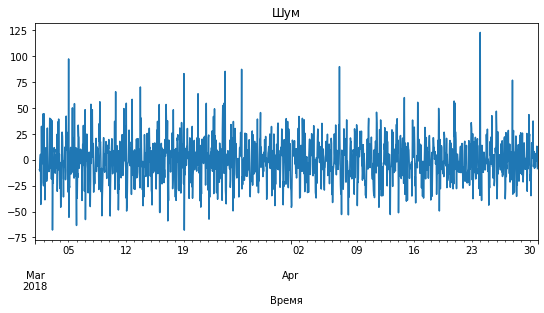

In [13]:
decomposed.resid['2018-03':'2018-04'].plot(title='Шум',figsize=[9,4],xlabel='Время');

Очевиден тренд на увеличение количества поездок такси с течением времени. Это так же говорит о нестационарности ряда.  
График сезонности говорит о том,что имеется явная цикличность в данных. При рассмотрении суточных циклов видно, что пики заказов приходятся на полночь, после чего происходит резкое снижение вплоть до минимума в 3 часа ночи. Также имеются пики меньшей величины перед обедом и в 15 часов. 

Сделаем функцию, которая производит смещение на определенное количество дней. 

In [14]:
def make_features(data, col , max_lag, rolling_mean_size):
    data.loc[:,'month'] = data.index.month
    data.loc[:,'day'] = data.index.day
    data.loc[:,'hour'] = data.index.hour
    data.loc[:,'dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 12):
        data['lag_{}'.format(lag)] = data.loc[:,col].shift(lag)

    data.loc[:,'rolling_mean'] = data.loc[:,col].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    return data
    

train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=12345)

train = make_features(train,'num_orders', 12, 24)
test =  make_features(test,'num_orders', 12, 24)

In [15]:
# получение признаков и целей тренировочной части
features_train = train.drop(['num_orders'], axis=1) 
target_train = train['num_orders']

# получение признаков и целей тестовой части
features_test = test.drop(['num_orders'], axis=1) 
target_test = test['num_orders']

In [16]:
df_result = pd.DataFrame(data={'Eval':[np.nan], 'RMSE':[np.nan]})

## Random Forest Regressor

In [17]:
model_rfr = RandomForestRegressor(random_state=12345)

param = {'n_estimators':[40,80], 'max_features':['auto','sqrt']}
tscv = TimeSeriesSplit(n_splits=4)

grid_rfr = GridSearchCV(estimator=model_rfr, cv=tscv, param_grid=param, 
                        scoring='neg_root_mean_squared_error')

grid_rfr.fit(features_train, target_train);

In [18]:
df_result.loc[0] = ['RandForReg',abs( grid_rfr.cv_results_['mean_test_score'][grid_rfr.best_index_])] 

## CatBoost

In [19]:
cat_boost = cb.CatBoostRegressor(iterations=70,random_state=12345)

#список гиперпараметров для перебора
param = {'learning_rate': [0.02, 0.04],'depth': [6,10]}
grid_cb = GridSearchCV(cat_boost, param, cv=tscv, scoring='neg_root_mean_squared_error')

grid_cb.fit(features_train,
         target_train,
         plot=False,
         verbose=False);

In [20]:
df_result.loc[len(df_result)] = ['CatBoost',
                                 abs( grid_cb.cv_results_['mean_test_score'][grid_cb.best_index_])] 

## LightGBM

In [21]:
gbm = lgb.LGBMRegressor(random_state=12345) #инициализируем регрессор

param = {'num_leaves': [4,20],'max_depth': [6,10]} #задаем параметры
grid_gbm = GridSearchCV(estimator=gbm, param_grid = param,cv=tscv,scoring='neg_root_mean_squared_error')

grid_gbm.fit(features_train,target_train);

In [22]:
df_result.loc[len(df_result)] = ['LightGBM',
                                 abs( grid_gbm.cv_results_['mean_test_score'][grid_gbm.best_index_])] 

In [23]:
df_result

,Eval,RMSE
0,RandForReg,26.428622
1,CatBoost,28.937490
2,LightGBM,25.794824


## Тест лучшей модели

In [24]:
best_gbm = lgb.LGBMRegressor(random_state=12345)
best_gbm.set_params(**grid_gbm.best_params_ )
best_gbm.fit(features_train,target_train)

predict = best_gbm.predict(features_test)

In [25]:
rmse_rfr = mean_squared_error(target_test, predict , squared=False)
print( 'RMSE lightGBM на тестовой выборке', round(rmse_rfr) )

RMSE lightGBM на тестовой выборке 43


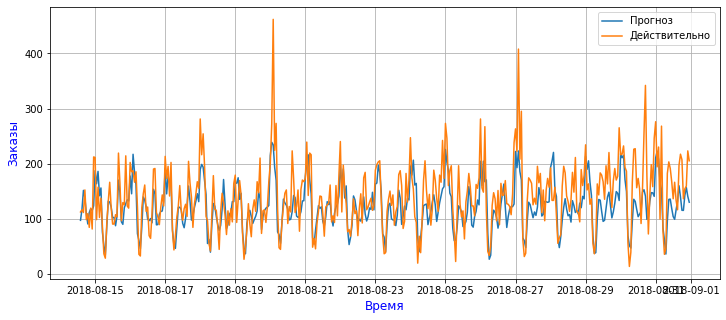

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(target_test.index,predict, target_test.index,target_test )
plt.title('', fontsize=15)
plt.xlabel('Время', fontsize=12, color='blue')
plt.ylabel('Заказы', fontsize=12, color='blue')
plt.legend(['Прогноз','Действительно'])
plt.grid(True)

Вывод: получен RMSE равный 43, что ниже требуемого по заданию 48. 